In [49]:
import re
import os
import nltk
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nltk.translate.meteor_score as meteor_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Attention
from tensorflow.keras.models import Model
from nltk.translate import bleu_score
from nltk.translate.bleu_score import SmoothingFunction
from nltk.util import ngrams
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping
from nltk.tokenize import word_tokenize
nltk.download('punkt')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mbeng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# PROCESSING THE TRAINING DATA 



In [50]:
### PROCESSING TRAINING DATA TO PUT IT ALL IN ONE FILE CALLED MERGED_FILE_TRAIN.MMF

train_folder = os.path.abspath('training_set/train')
source_folders = [train_folder]

# Specify the path of the output merged MMF file
output_train_file = 'training_set/merged_file_train.mmf'

# Initialize the recipe count
recipe_count = 0

# Open the output file in write mode
with open(output_train_file, 'w') as outfile:
    # Iterate through each source folder
    for source_folder in source_folders:
        # Iterate through all files in the source folder
        for filename in os.listdir(source_folder):
            if filename.endswith('.mmf'):
                file_path = os.path.join(source_folder, filename)
                # Read the content of each MMF file
                with open(file_path, 'r') as infile:
                    # Initialize an empty dictionary for each recipe object
                    recipe = {}
                    # Flag to indicate if the ingredients section has been encountered
                    ingredients_section = False

                    # Iterate through each line in the MMF file
                    for line in infile:
                        line = line.strip()  # Remove leading/trailing white space

                        if not line:  # Skip empty lines
                            continue

                        if line.endswith('END RECIPE'):
                            # End of recipe, write the recipe object to the output file
                            outfile.write('Title: ' + recipe['Title'] + '\n')
                            outfile.write('categories: ' + recipe['categories'] + '\n')
                            outfile.write('servings: ' + recipe['servings'] + '\n')
                            outfile.write('ingredients: ' + recipe['ingredients'] + '\n')
                            if 'instructions' in recipe:
                                outfile.write('instructions: ' + str(recipe['instructions']) + '\n')
                            else:
                                outfile.write('instructions: \n')
                            outfile.write('\n')
                            recipe = {}  # Reset the recipe dictionary for the next recipe
                            recipe_count += 1
                            ingredients_section = False  # Reset the ingredients section flag
                        elif line == 'ingredients:':
                            # Start of the ingredients section
                            ingredients_section = True
                        elif ':' in line and not ingredients_section:
                            # Split the line into key and value
                            key, value = line.split(':', 1)
                            key = key.strip()  # Remove leading/trailing white space
                            value = value.strip()  # Remove leading/trailing white space
                            recipe[key] = value  # Add the key-value pair to the recipe dictionary
                        else:
                            # Handle lines without a colon or within the ingredients section
                               # Handle lines without a colon or within the ingredients section
                            if 'instructions' not in recipe:
                                recipe['instructions'] = ''
                            recipe['instructions'] += line.strip() + ' '
                    # Increment the recipe count after processing each file
                    recipe_count += 1

print(f"Successfully merged the MMF files into {output_train_file}.")
print('Total number of recipes:', recipe_count)

Successfully merged the MMF files into training_set/merged_file_train.mmf.
Total number of recipes: 85282


In [51]:
#### CLEANING THE DATA ###
output_train_file = os.path.abspath('training_set/merged_file_train.mmf')

# Read the content of the merged MMF file
with open(output_train_file, 'r') as merged_file:
    merged_content = merged_file.read()


# Function to clean and standardize the format of ingredients
def clean_ingredients(ingredients):
    # Define multiple noize_strings
    noize_strings = ['tb', 'oz', 'ts', 'tbsp', 'c', 'qt', 'lb']
    
    # Join the noize_strings into a single pattern for easier replacement
    noize_pattern = '|'.join(noize_strings)

    ingredients = re.sub(r'\(.*?\)', '', ingredients)  # Remove anything inside parentheses
    ingredients = re.sub(r'[0-9/]+', '', ingredients)  # Remove measurement units
    ingredients = re.sub(r'->', '', ingredients)  # Remove arrows
    ingredients = re.sub(noize_pattern, '', ingredients)  # Remove the defined noize_strings
    ingredients = re.sub(r'\s+', ' ', ingredients).strip()  # Remove extra spaces and standardize spacing
    ingredients = re.sub(r'[^\w\s]', '', ingredients.lower())
    return ingredients


# Function to clean and standardize the format of instructions
def clean_instructions(instructions):
    # Define multiple noize_strings
    noize_strings = ['tb', 'oz', 'ts', 'tbsp', 'c', 'qt', 'lb']
    # Join the noize_strings into a single pattern for easier replacement
    noize_pattern = '|'.join(noize_strings)

    instructions = instructions.replace('\n', ' ')  # Remove line breaks
    instructions = re.sub(noize_pattern, '', instructions)  # Remove the defined noize_strings
    instructions = re.sub(r'\s+', ' ', instructions).strip()  # Remove extra spaces and standardize spacing
    instructions = re.sub(r'[^\w\s]', '', instructions.lower())
    return instructions

# Split the content into individual recipe objects
train_recipes = merged_content.split('\n\n')

# Function to Parse each recipe string into a dictionary and clean ingredients and instructions
def parse_recipe(recipe_string):
    recipe_dict = {}
    lines = recipe_string.strip().split('\n')
    for line in lines:
        try:
            key, value = line.split(': ', 1)
            if key == 'ingredients':
                value = clean_ingredients(value)
                recipe_dict[key] = value
            elif key == 'instructions':
                value = clean_instructions(value)
                recipe_dict[key] = value
            # Ignore title, categories, and servings from the recipe dictionary
        except ValueError:
            # Skip lines that don't follow the expected key-value format
            continue
    return recipe_dict


# Function to Parse each recipe string into a dictionary and clean ingredients and instructions
train_parsed_recipes = [parse_recipe(recipe) for recipe in train_recipes]

In [52]:
# Function to print an example of a parsed recipe
def print_parsed_recipe(recipe):
    if recipe:
        for key, value in recipe.items():
            print(f"{key}: {value}")
    else:
        print("Recipe not found.")

# Get a recipe from the parsed_recipes list
train_recipe = train_parsed_recipes[3000] if train_parsed_recipes else None
print_parsed_recipe(train_recipe)

ingredients: lg whole kale leaves washed and trimmed dash lemon juie dash garli powder dijon or spiy brown mustard whole wheat pita bread
instructions: steam the kale for 2 minutes and drain off any liquid  sprinkle with lemon juie and garli powder and hill  when ready to serve  ut the pita bread in half  spread eah poket with mustard  and then stuff with the old seasoned kale 


In [53]:
#This is making sure the each recipe used for training has the required data
def recipe_validate_required_fields(recipe):
    required_keys = ['ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if required_key not in recipe or not recipe[required_key]:
            return False
        
        if isinstance(recipe[required_key], list) and len(recipe[required_key]) == 0:
            return False
    
    return True


# Filter the recipes and create a validated dataset
train_dataset_validated = [recipe for recipe in train_parsed_recipes if recipe_validate_required_fields(recipe)]
print('Dataset size AFTER validation', len(train_dataset_validated))

Dataset size AFTER validation 85135


In [54]:
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

# Function to stringify the recipes and remove noise words
def recipe_to_string(recipe):
    # These strings are presented as a part of recipes so we need to clean it up.
    noize_strings = ['tb', 'oz', 'ts', 'tbsp', 'c', 'qt', 'lb']
        
    # Join the noize_strings into a single pattern for easier replacement
    noize_pattern = '|'.join(noize_strings)
    
    ingredients = recipe['ingredients'].split('\t')
    instructions = recipe['instructions'].split('.')  
    
    # Remove the noize_strings from ingredients and instructions
    ingredients_cleaned = [re.sub(noize_pattern, '', ingredient) for ingredient in ingredients]
    instructions_cleaned = [re.sub(noize_pattern, '', instruction) for instruction in instructions]

    # Build the ingredients and instructions strings
    ingredients_string = ''
    for ingredient in ingredients_cleaned:
        ingredient = ingredient.strip()
        if ingredient:
            ingredients_string += f'  • {ingredient}\n'

    instructions_string = ''
    for instruction in instructions_cleaned:
        instruction = instruction.strip()
        if instruction:
            instructions_string += f'  ▪︎ {instruction}\n'

    return f'{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'


train_dataset_stringified = [recipe_to_string(recipe) for recipe in train_dataset_validated]
print('Stringified dataset size: ', len(train_dataset_stringified))

Stringified dataset size:  85135


In [55]:
for recipe_index, recipe_string in enumerate(train_dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------

🥕

  • navy beans dry small bee lean beef green abbage shredded slab baon large leeks slied old water medium potatoes ut bay leaf into eighths whole pepperorns n tomatoes loves garli tomato paste dried parsley red wine vinegar arrot sugar elery stalk kieasa large red onion flour salt butter melted bee for soup sour ream

📝

  ▪︎ over beans with water and allow to soak overnight  ook until tender  drain  set aside  plae beef  baon and water in large soup pot  bring to a boil  skim fat from surfae  add bay leaf  pepperorns  garli  parsley  arrot  elery  onion and salt  over and simmer over low heat for about 112 hours  srub bee for soup and ook in boiling water until tender  about 45 minutes  drain and disard water  ool  peel and ut eah beet into eighths  srub small bee  grate  over with water to soak  remove meat from soup  set aside  strain soup into another pot and add ooked bee  abbage  leeks  potatoes  tomatoes  tomato paste  vinegar  sugar  beef and baon  bring

# PROCESSING THE DEV DATA

In [56]:
### PROCESSING DEV DATA TO PUT IT ALL IN ONE FILE CALLED MERGED_FILE_DEV.MMF

dev_folder = os.path.abspath('training_set/dev')
source_folders = [dev_folder]

# Specify the path of the output merged MMF file
output_dev_file = 'training_set/merged_file_dev.mmf'

# Initialize the recipe count
recipe_count = 0

# Open the output file in write mode
with open(output_dev_file, 'w') as outfile:
    # Iterate through each source folder
    for source_folder in source_folders:
        # Iterate through all files in the source folder
        for filename in os.listdir(source_folder):
            if filename.endswith('.mmf'):
                file_path = os.path.join(source_folder, filename)
                # Read the content of each MMF file
                with open(file_path, 'r') as infile:
                    # Initialize an empty dictionary for each recipe object
                    recipe = {}
                    # Flag to indicate if the ingredients section has been encountered
                    ingredients_section = False

                    # Iterate through each line in the MMF file
                    for line in infile:
                        line = line.strip()  # Remove leading/trailing white space

                        if not line:  # Skip empty lines
                            continue

                        if line.endswith('END RECIPE'):
                            # End of recipe, write the recipe object to the output file
                            outfile.write('Title: ' + recipe['Title'] + '\n')
                            outfile.write('categories: ' + recipe['categories'] + '\n')
                            outfile.write('servings: ' + recipe['servings'] + '\n')
                            outfile.write('ingredients: ' + recipe['ingredients'] + '\n')
                            if 'instructions' in recipe:
                                outfile.write('instructions: ' + str(recipe['instructions']) + '\n')
                            else:
                                outfile.write('instructions: \n')
                            outfile.write('\n')
                            recipe = {}  # Reset the recipe dictionary for the next recipe
                            recipe_count += 1
                            ingredients_section = False  # Reset the ingredients section flag
                        elif line == 'ingredients:':
                            # Start of the ingredients section
                            ingredients_section = True
                        elif ':' in line and not ingredients_section:
                            # Split the line into key and value
                            key, value = line.split(':', 1)
                            key = key.strip()  # Remove leading/trailing white space
                            value = value.strip()  # Remove leading/trailing white space
                            recipe[key] = value  # Add the key-value pair to the recipe dictionary
                        else:
                            # Handle lines without a colon or within the ingredients section
                               # Handle lines without a colon or within the ingredients section
                            if 'instructions' not in recipe:
                                recipe['instructions'] = ''
                            recipe['instructions'] += line.strip() + ' '
                    # Increment the recipe count after processing each file
                    recipe_count += 1

print(f"Successfully merged the MMF files into {output_dev_file}.")
print('Total number of recipes:', recipe_count)

Successfully merged the MMF files into training_set/merged_file_dev.mmf.
Total number of recipes: 846


In [57]:
#### CLEANING THE DATA ###
output_dev_file = os.path.abspath('training_set/merged_file_dev.mmf')

# Read the content of the merged MMF file
with open(output_dev_file, 'r') as merged_file:
    merged_content = merged_file.read()

# Split the content into individual recipe objects
dev_recipes = merged_content.split('\n\n')

# Parse each recipe string into a dictionary and clean ingredients and instructions
dev_parsed_recipes = [parse_recipe(recipe) for recipe in dev_recipes]

In [58]:
# Get a recipe from the parsed_recipes list
dev_recipe = dev_parsed_recipes[130] if dev_parsed_recipes else None
print_parsed_recipe(dev_recipe)

ingredients: mini marshmallows peanut butter margarine rie hex orn hex m  ms
instructions: grease a 9 x 13 pan  in a mirowave safe bowl  mirowave marshmallows  peanut butter and margarine for two minutes or until melted  stir until smooth  add ereal and m  m s  stirring to oat all piees  spread mixture in prepared pan and press dowm slightly with the bak of a buttered spoon  regrigerate for one hour  pull piees from pan or ut into squares 


In [59]:
#This is making sure the each recipe used for training has the required data
dev_dataset_validated = [recipe for recipe in dev_parsed_recipes if recipe_validate_required_fields(recipe)]
print('Dataset size AFTER validation', len(dev_dataset_validated))

Dataset size AFTER validation 710


In [60]:
# Function to stringify the recipes and remove noise words
dev_dataset_stringified = [recipe_to_string(recipe) for recipe in dev_dataset_validated]
print('Stringified dataset size: ', len(dev_dataset_stringified))

Stringified dataset size:  710


In [61]:
for recipe_index, recipe_string in enumerate(dev_dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------

🥕

  • sugar unbleahed flour salt instant nonfat dry milk

📝

  ▪︎ ombine all ingredien in a large bowl  mix well  put in a large airtight ontainer and label as pudding and pie mix  store in a ool  dry plae and use within 6 to 8 months



Recipe #2
---------

🥕

  • sugar paprika dry mustard salt onion powder

📝

  ▪︎ ombine all ingredien in a small bowl  stir until well blended  put mixture in a foil paket or 1pint glass jar and label as frenh dressing mix  stor in a ool  dry plae and use within 6 months



Recipe #3
---------

🥕

  • brown sugar firmly paked unbleahed flour innamon or to taste nutmeg butter or margarine

📝

  ▪︎ in a medium bowl  ombine brown sugar  flour and spies  blend well  with a pastry blender ut in butter or margarine until mixture is very fine  put in a 1quart airtight ontainer and label as rumb topping mix  store in the refregator and use within 1 to 2 months





# PROCESSING THE TEST DATA

In [62]:
# Specify the path of the output merged MMF file
output_test_file = 'test/merged_file_test.mmf'

# Initialize the recipe count
recipe_count = 0

test_folder = os.path.abspath('test') 

# Define the list of source folders
source_folders = [test_folder]

# Open the output file in write mode
with open(output_test_file, 'w') as outfile:
    # Iterate through each source folder
    for source_folder in source_folders:
        if not os.path.exists(source_folder):  # Check if the folder exists
            print(f"Source folder '{source_folder}' doesn't exist. Skipping...")
            continue

        # Iterate through all files in the source folder
        for filename in os.listdir(source_folder):
            if filename.endswith('.mmf'):
                file_path = os.path.join(source_folder, filename)
                # Read the content of each MMF file
                with open(file_path, 'r') as infile:
                    # Initialize an empty dictionary for each recipe object
                    recipe = {}
                    # Flag to indicate if the ingredients section has been encountered
                    ingredients_section = False

                    # Iterate through each line in the MMF file
                    for line in infile:
                        line = line.strip()  # Remove leading/trailing white space

                        if not line:  # Skip empty lines
                            continue

                        if line.endswith('END RECIPE'):
                            # End of recipe, write the recipe object to the output file
                            outfile.write('Title: ' + recipe['Title'] + '\n')
                            outfile.write('categories: ' + recipe['categories'] + '\n')
                            outfile.write('servings: ' + recipe['servings'] + '\n')
                            outfile.write('ingredients: ' + recipe['ingredients'] + '\n')
                            if 'instructions' in recipe:
                                outfile.write('instructions: ' + str(recipe['instructions']) + '\n')
                            else:
                                outfile.write('instructions: \n')
                            outfile.write('\n')
                            recipe = {}  # Reset the recipe dictionary for the next recipe
                            recipe_count += 1
                            ingredients_section = False  # Reset the ingredients section flag
                        elif line == 'ingredients:':
                            # Start of the ingredients section
                            ingredients_section = True
                        elif ':' in line and not ingredients_section:
                            # Split the line into key and value
                            key, value = line.split(':', 1)
                            key = key.strip()  # Remove leading/trailing white space
                            value = value.strip()  # Remove leading/trailing white space
                            recipe[key] = value  # Add the key-value pair to the recipe dictionary
                        else:
                            # Handle lines without a colon or within the ingredients section
                               # Handle lines without a colon or within the ingredients section
                            if 'instructions' not in recipe:
                                recipe['instructions'] = ''
                            recipe['instructions'] += line.strip() + ' '
                    # Increment the recipe count after processing each file
                    recipe_count += 1

print(f"Successfully merged the MMF files into {output_test_file}.")
print('Total number of recipes:', recipe_count)


Successfully merged the MMF files into test/merged_file_test.mmf.
Total number of recipes: 827


In [63]:
#### CLEANING THE TEST DATA ###
output_test_file = os.path.abspath('test/merged_file_test.mmf')

# Read the content of the merged MMF file
with open(output_test_file, 'r') as merged_file:
    merged_content = merged_file.read()

# Split the content into individual recipe objects
test_recipes = merged_content.split('\n\n')

# Parse each recipe string into a dictionary and clean ingredients and instructions
test_parsed_recipes = [parse_recipe(recipe) for recipe in test_recipes]

In [64]:
# Get a recipe from the parsed_recipes list
test_recipe = test_parsed_recipes[30] if test_parsed_recipes else None
print_parsed_recipe(test_recipe)


ingredients: to pakage ream heese softened grated lemon rind hopped nu strawberries well drained and hopped into small piees brown bread or whole wheat rakers
instructions: ombine the ream heese and lemon rind  blend in the nu and berries  spread the mixture on top of small piees of bread  ut into rounds or squares  or on rakers 


In [65]:
#This is making sure the each recipe used for training has the required data
test_dataset_validated = [recipe for recipe in test_parsed_recipes if recipe_validate_required_fields(recipe)]
print('Dataset size AFTER validation', len(train_dataset_validated))

Dataset size AFTER validation 85135


In [66]:
# Function to stringify the recipes and remove noise words
test_dataset_stringified = [recipe_to_string(recipe) for recipe in test_dataset_validated]
print('Stringified dataset size: ', len(test_dataset_stringified))

Stringified dataset size:  690


In [67]:
for recipe_index, recipe_string in enumerate(test_dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------

🥕

  • unbleahed flour whole wheat flour salt baking powder baking soda brown sugar firmly paked vegetable shortening quik rolled oa

📝

  ▪︎ ombine all ingredien exept the sugar  shortening  and oa in a large bowl  blend well  stir ni brown sugar an mix well  with a pastry blender  ut in shortening until evenly distributed  stir in oa and mix well  put in a large airtight ontainer and label oatmeal ookie mix  store in a ool  dry plae and use within 10 to 12 weeks



Recipe #2
---------

🥕

  • heddar heese grated ayenne pepper unsalted butter softened pimientostuffed olives

📝

  ▪︎ drain olives and pat dry with towels  ombine heese and butter in a bowl  add flour and ayenne and blend until well mixed  drop the dough by tablespoons onto wax paper and wrap or mold eah piee of dough around an olive  overing it ompletely  bake the wrapped olives on a baking sheet in the middle of a preheated 400f oven for 15 minutes or until golden  serve warm



Recipe #3
---------


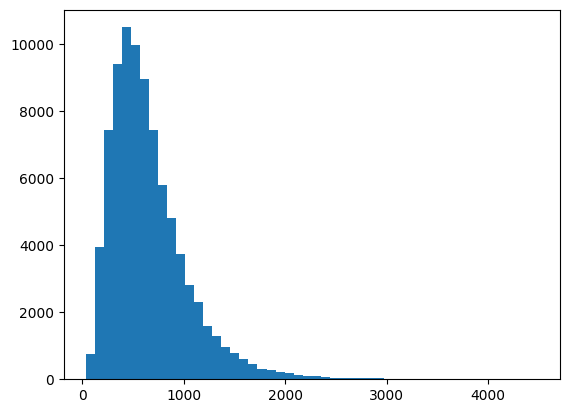

In [68]:
recipes_lengths = []
for recipe_text in train_dataset_stringified:
    recipes_lengths.append(len(recipe_text))
plt.hist(recipes_lengths, bins=50)
plt.show()

In [69]:
MAX_RECIPE_LENGTH = 150

In [70]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 
train_dataset_filtered = [recipe_text for recipe_text in train_dataset_stringified if filter_recipes_by_length(recipe_text)]
test_dataset_filtered = [recipe_text for recipe_text in test_dataset_stringified if filter_recipes_by_length(recipe_text)]
dev_dataset_filtered = [recipe_text for recipe_text in dev_dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Train Dataset size AFTER filtering: ', len(train_dataset_filtered))
print('Test Dataset size AFTER filtering: ', len(test_dataset_filtered))
print('Dev Dataset size AFTER filtering: ', len(dev_dataset_filtered))


Train Dataset size AFTER filtering:  1429
Test Dataset size AFTER filtering:  16
Dev Dataset size AFTER filtering:  13


# TOKENIZE THE TRAIN DATA

In [72]:
# Define 🥕 and 📝 symbols
INGREDIENTS_START = '🥕'
INSTRUCTIONS_START = '📝'

# Split ingredients and instructions using 🥕 and 📝 as delimiters
train_ingredients = [INGREDIENTS_START + recipe.split(INSTRUCTIONS_START)[0].strip() for recipe in train_dataset_stringified]
train_instructions = [INSTRUCTIONS_START + recipe.split(INSTRUCTIONS_START)[1].strip() for recipe in train_dataset_stringified]

# Tokenize the train recipe text
train_tokenizer = Tokenizer(filters='\n')
train_tokenizer.fit_on_texts(train_dataset_filtered)

train_ingredients_sequences = train_tokenizer.texts_to_sequences(train_ingredients)
train_instructions_sequences = train_tokenizer.texts_to_sequences(train_instructions)

# Pad the sequences
train_ingredients_padded = pad_sequences(train_ingredients_sequences, maxlen=MAX_RECIPE_LENGTH, padding='post')
train_instructions_padded = pad_sequences(train_instructions_sequences, maxlen=MAX_RECIPE_LENGTH, padding='post')

#Input and Output data
train_encoder_input_data = train_ingredients_padded
train_decoder_input_data = np.hstack((np.ones((train_instructions_padded.shape[0], 1)), train_instructions_padded[:, :-1]))
train_decoder_output_data = train_instructions_padded


In [73]:
# Function to decode sequence so l can confirm the output data
def decode_sequence(input_sequence, tokenizer):
    decoded_text = tokenizer.sequences_to_texts(input_sequence)[0]
    return decoded_text

# Select an example index
example_index = 456

# Decode the dev_encoder_input_data and dev_decoder_input_data sequences
decoded_train_ingredients = decode_sequence(train_encoder_input_data[example_index].reshape(1, -1), train_tokenizer)
decoded_train_instructions = decode_sequence(train_decoder_input_data[example_index].reshape(1, -1), train_tokenizer)

# Print the decoded ingredients and instructions
print("Decoded Ingredients:\n", decoded_train_ingredients)
print("Decoded Instructions:\n", decoded_train_instructions)

Decoded Ingredients:
 • vegetable oil milk salt pn nutmeg pn pepper ea egg yolks lightly beaten parmesan heese grated butter semolina flour
Decoded Instructions:
 🥕 bottom of 15 x 10 x 1 inh pan with aluminum foil oil the foil heat milk salt nutmeg and pepper in heavy 3 quart sauepan over medium high heat just to redue heat to medium low or stirring add egg yolks 34 up of the heese and 2 of the butter to semolina mixture stir until butter is melted and mixture is smooth mixture to prepared pan pat out with to 38 inh thik refrigerate until old at least 1 hour heat oven to 425 degrees turn mixture out of pan onto flat surfae peel off foil ut out of mixture with 2 inh round utter in 10 inh shallow baking dish melt remaining 4 tablespoon butter in small sauepan drizzle melted


# TOKENIZE THE DEV DATA

In [74]:
# Define 🥕 and 📝 symbols
INGREDIENTS_START = '🥕'
INSTRUCTIONS_START = '📝'

# Split ingredients and instructions using 🥕 and 📝 as delimiters
dev_ingredients = [INGREDIENTS_START + recipe.split(INSTRUCTIONS_START)[0].strip() for recipe in dev_dataset_stringified]
dev_instructions = [INSTRUCTIONS_START + recipe.split(INSTRUCTIONS_START)[1].strip() for recipe in dev_dataset_stringified]

# Tokenize the train recipe text
dev_tokenizer = Tokenizer(filters='\n')
dev_tokenizer.fit_on_texts(dev_dataset_filtered)

dev_ingredients_sequences = dev_tokenizer.texts_to_sequences(dev_ingredients)
dev_instructions_sequences = dev_tokenizer.texts_to_sequences(dev_instructions)

# Pad the sequences
dev_ingredients_padded = pad_sequences(dev_ingredients_sequences, maxlen=MAX_RECIPE_LENGTH, padding='post')
dev_instructions_padded = pad_sequences(dev_instructions_sequences, maxlen=MAX_RECIPE_LENGTH, padding='post')

#Input and Output data
dev_encoder_input_data = dev_ingredients_padded
dev_decoder_input_data = np.hstack((np.ones((dev_instructions_padded.shape[0], 1)), dev_instructions_padded[:, :-1]))
dev_decoder_output_data = dev_instructions_padded


In [75]:
# decode sequence so l can confirm the output data
# Select an example index (you can change this to any other index you want to check)
example_index = 9

# Decode the dev_encoder_input_data and dev_decoder_input_data sequences
decoded_dev_ingredients = decode_sequence(dev_encoder_input_data[example_index].reshape(1, -1), dev_tokenizer)
decoded_dev_instructions = decode_sequence(dev_decoder_input_data[example_index].reshape(1, -1), dev_tokenizer)

# Print the decoded ingredients and instructions
print("Decoded Ingredients:\n", decoded_dev_ingredients)
print("Decoded Instructions:\n", decoded_dev_instructions)


Decoded Ingredients:
 • and tomato oil to a juie of lemon mined parsley salt and pepper to taste hot pepper saue and
Decoded Instructions:
 🥕 sour ream or in a or a to in a bowl the tomato and oil with lemon juie to the the lemon juie and parsley to the tomato stir to mix well season to taste with salt and pepper and a of drops of hot pepper saue several serving at serving taste soup for into bowl and with and sour ream hot pepper saue to


# TOKENIZE THE TEST DATA

In [76]:
# Define 🥕 and 📝 symbols
INGREDIENTS_START = '🥕'
INSTRUCTIONS_START = '📝'

# Split ingredients and instructions using 🥕 and 📝 as delimiters
test_ingredients = [INGREDIENTS_START + recipe.split(INSTRUCTIONS_START)[0].strip() for recipe in test_dataset_stringified]
test_instructions = [INSTRUCTIONS_START + recipe.split(INSTRUCTIONS_START)[1].strip() for recipe in test_dataset_stringified]


# Tokenize the train recipe text
test_tokenizer = Tokenizer(filters='\n')
test_tokenizer.fit_on_texts(test_dataset_filtered)

test_ingredients_sequences = test_tokenizer.texts_to_sequences(test_ingredients)
test_instructions_sequences = test_tokenizer.texts_to_sequences(test_instructions)

# Pad the sequences

test_ingredients_padded = pad_sequences(test_ingredients_sequences, maxlen=MAX_RECIPE_LENGTH, padding='post')
test_instructions_padded = pad_sequences(test_instructions_sequences, maxlen=MAX_RECIPE_LENGTH, padding='post')

#Input and Output data
test_encoder_input_data = test_ingredients_padded
test_decoder_input_data = np.hstack((np.ones((test_instructions_padded.shape[0], 1)), test_instructions_padded[:, :-1]))
test_decoder_output_data = test_instructions_padded

In [77]:
# decode sequence so l can confirm the output data
# Select an example index
example_index = 78

# Decode the dev_encoder_input_data and dev_decoder_input_data sequences
decoded_test_ingredients = decode_sequence(test_encoder_input_data[example_index].reshape(1, -1), test_tokenizer)
decoded_test_instructions = decode_sequence(test_decoder_input_data[example_index].reshape(1, -1), test_tokenizer)

# Print the decoded ingredients and instructions
print("Decoded Ingredients:\n", decoded_test_ingredients)
print("Decoded Instructions:\n", decoded_test_instructions)

Decoded Ingredients:
 • baking salt milk butter
Decoded Instructions:
 🥕 ombine baking and salt ut in until and milk until dry into 12 plae on a bake for and bake serve with butter


# BUILD THE MODEL

In [29]:
# Model architecture
vocab_size = len(train_tokenizer.word_index) + 1
hidden_size = 256

print(vocab_size)

2582


In [30]:

# Encoder
encoder_input = tf.keras.layers.Input(shape=(MAX_RECIPE_LENGTH,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=hidden_size)(encoder_input)
encoder_lstm = LSTM(hidden_size, return_sequences=True, dropout=0.1, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_input = tf.keras.layers.Input(shape=(MAX_RECIPE_LENGTH,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=hidden_size)(decoder_input)
decoder_lstm = LSTM(hidden_size, return_sequences=True, dropout=0.1, return_state=True)
decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Attention layer
attention = tf.keras.layers.Attention()
context_vector = attention([decoder_output, encoder_output])

# Concatenate context vector and decoder output
decoder_combined_context = tf.keras.layers.concatenate([context_vector, decoder_output])

# Final output layer
output = Dense(vocab_size, activation='softmax')
decoder_pred = output(decoder_combined_context)

#Early Stopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Define the model
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_pred)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


In [31]:
start_time = time.time()
# Train the model using train dataset
dev_attention_model = model.fit(
                    [dev_encoder_input_data, dev_decoder_input_data],
                    np.expand_dims(dev_decoder_output_data , axis=-1),
                    batch_size=256,
                    epochs=40, 
                    validation_data=([test_encoder_input_data, test_decoder_input_data], 
                    np.expand_dims(test_decoder_output_data, axis=-1)),
                    callbacks=[early_stopping]
                )

# End tracking time
end_time = time.time()
total_time = end_time - start_time
print(f"Total dev training time: {total_time:.2f} seconds")

model_name = ('dev_attention_model.keras')
model.save(model_name)

Epoch 1/40
3/3 [==============================] - 11s 3s/step - loss: 7.7421 - val_loss: 7.3386
Epoch 2/40
3/3 [==============================] - 8s 3s/step - loss: 6.4659 - val_loss: 3.9394
Epoch 3/40
3/3 [==============================] - 8s 3s/step - loss: 3.0081 - val_loss: 2.1534
Epoch 4/40
3/3 [==============================] - 8s 3s/step - loss: 1.7409 - val_loss: 2.1573
Epoch 5/40
3/3 [==============================] - 8s 3s/step - loss: 1.6301 - val_loss: 2.1637
Epoch 6/40
3/3 [==============================] - 8s 3s/step - loss: 1.4840 - val_loss: 2.1044
Epoch 7/40
3/3 [==============================] - 8s 3s/step - loss: 1.3924 - val_loss: 2.1393
Epoch 8/40
3/3 [==============================] - 8s 3s/step - loss: 1.3768 - val_loss: 2.0784
Epoch 9/40
3/3 [==============================] - 8s 3s/step - loss: 1.3109 - val_loss: 1.9798
Epoch 10/40
3/3 [==============================] - 8s 3s/step - loss: 1.2575 - val_loss: 1.9127
Epoch 11/40
3/3 [==============================]

# PLOT WITH DEV DATA

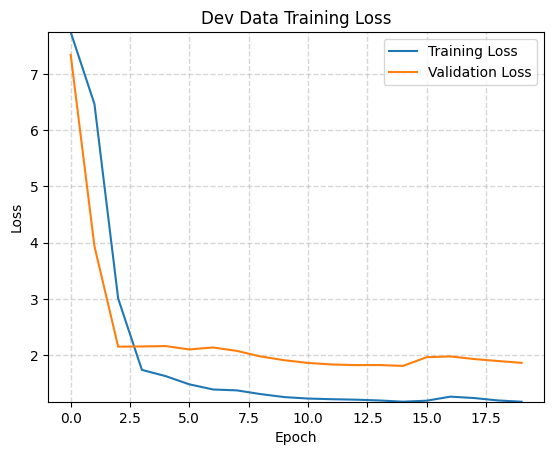

In [32]:

# Function to plot training history
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']  # Validation loss
    
    plt.title('Dev Data Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    
    # Set the y-axis limits to the desired range (e.g., from -1 to 0)
    min_loss = min(min(loss), min(val_loss))
    max_loss = max(max(loss), max(val_loss))
    
    # Set the y-axis limits to the minimum and maximum loss values
    plt.ylim(min_loss, max_loss)
    plt.show()
    
# Plot the training history
render_training_history(dev_attention_model)

In [33]:
start_time = time.time()
# Train the model
train_attention_model = model.fit(
                    [train_encoder_input_data, train_decoder_input_data],
                    np.expand_dims(train_decoder_output_data , axis=-1),
                    batch_size=256,
                    epochs=40, 
                    validation_data=([test_encoder_input_data, test_decoder_input_data], 
                    np.expand_dims(test_decoder_output_data, axis=-1)),
                    callbacks=[early_stopping]
                )

# End tracking time
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

model_name = ('train_attention_model.keras')
model.save(model_name)

Epoch 1/40
333/333 [==============================] - 699s 2s/step - loss: 2.8609 - val_loss: 1.4563
Epoch 2/40
333/333 [==============================] - 699s 2s/step - loss: 2.3109 - val_loss: 1.5710
Epoch 3/40
333/333 [==============================] - 699s 2s/step - loss: 1.9775 - val_loss: 1.6446
Epoch 4/40
333/333 [==============================] - 699s 2s/step - loss: 1.8386 - val_loss: 1.6857
Epoch 5/40
333/333 [==============================] - 700s 2s/step - loss: 1.7524 - val_loss: 1.6956
Epoch 6/40
333/333 [==============================] - 702s 2s/step - loss: 1.6904 - val_loss: 1.7167
Total training time: 4197.56 seconds


# PLOT WITH TRAIN DATA

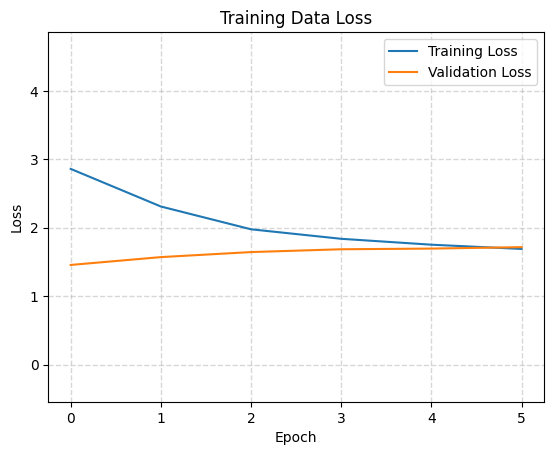

In [34]:

# Function to plot training history
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']  # Validation loss
    
    plt.title('Training Data Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    
    # Set the y-axis limits to the desired range (e.g., from -1 to 0)
    min_loss = min(min(loss), min(val_loss)) - 2
    max_loss = max(max(loss), max(val_loss)) + 2
    
    # Set the y-axis limits to the minimum and maximum loss values
    plt.ylim(min_loss, max_loss)
    plt.show()
    
render_training_history(train_attention_model)

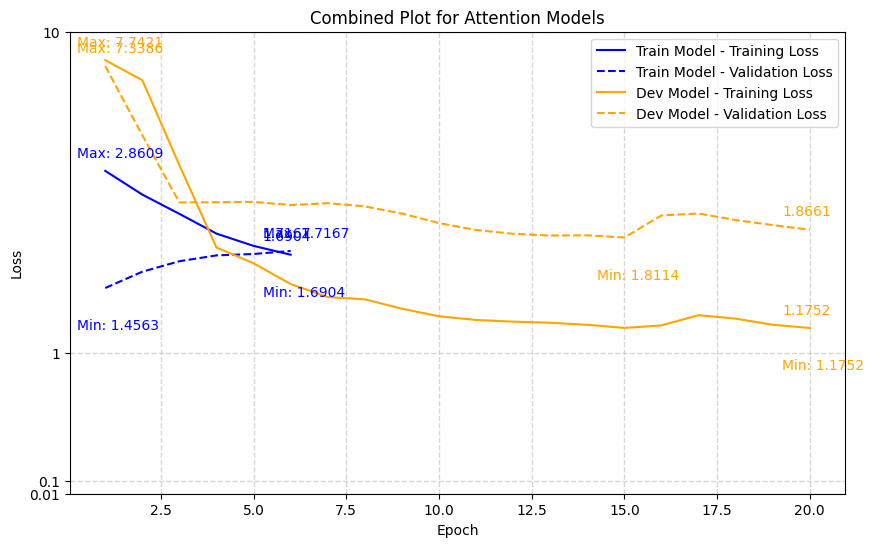

In [45]:
# Function to plot training history for multiple models
def render_training_history_multi_models(training_histories, model_labels):
    plt.figure(figsize=(10, 6))
    line_styles = ['-', '--']  # Solid and dashed line styles for training and dev sets
    colors = ['blue', 'orange']  # Colors for each model
    
    for i, training_history in enumerate(training_histories):
        loss = training_history.history['loss']
        val_loss = training_history.history['val_loss']
        epochs = len(loss)
        
        plt.plot(range(1, epochs + 1), loss, label=f'{model_labels[i]} - Training Loss', color=colors[i], linestyle=line_styles[0])
        plt.plot(range(1, epochs + 1), val_loss, label=f'{model_labels[i]} - Validation Loss', color=colors[i], linestyle=line_styles[1])
    
    plt.title('Combined Plot for Attention Models')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.yscale('symlog')
    
    # Add explicit tick labels on the y-axis
    plt.yticks([0.01, 0.1, 1, 10], [0.01, 0.1, 1, 10])
    
    # Add y-axis values as annotations
    for i, training_history in enumerate(training_histories):
        loss = training_history.history['loss']
        val_loss = training_history.history['val_loss']
        epochs = len(loss)
        
        # Annotate the last value of training loss
        plt.annotate(f'{loss[-1]:.4f}', xy=(epochs, loss[-1]), xytext=(-20, 10), textcoords='offset points', color=colors[i])
        
        # Annotate the last value of validation loss
        plt.annotate(f'{val_loss[-1]:.4f}', xy=(epochs, val_loss[-1]), xytext=(-20, 10), textcoords='offset points', color=colors[i])
        
        # Annotate the minimum value of training loss
        min_loss_index = loss.index(min(loss))
        plt.annotate(f'Min: {min(loss):.4f}', xy=(min_loss_index + 1, min(loss)), xytext=(-20, -30), textcoords='offset points', color=colors[i])
        
        # Annotate the minimum value of validation loss
        min_val_loss_index = val_loss.index(min(val_loss))
        plt.annotate(f'Min: {min(val_loss):.4f}', xy=(min_val_loss_index + 1, min(val_loss)), xytext=(-20, -30), textcoords='offset points', color=colors[i])
        
        # Annotate the maximum value of training loss
        max_loss_index = loss.index(max(loss))
        plt.annotate(f'Max: {max(loss):.4f}', xy=(max_loss_index + 1, max(loss)), xytext=(-20, 10), textcoords='offset points', color=colors[i])
        
        # Annotate the maximum value of validation loss
        max_val_loss_index = val_loss.index(max(val_loss))
        plt.annotate(f'Max: {max(val_loss):.4f}', xy=(max_val_loss_index + 1, max(val_loss)), xytext=(-20, 10), textcoords='offset points', color=colors[i])
    
    plt.show()
    
# Plot the training history for both models
render_training_history_multi_models([train_attention_model, dev_attention_model], 
                                    ['Train Model', 'Dev Model'])

In [36]:
# Print the model summary
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 150, 256)             660992    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 150, 256)             660992    ['input_2[0][0]']             
                                                                                              

# FUNCTION FOR FINAL OUTPUTS

In [38]:
#Function to generate text from the model
def generate_text(model, input_sequence, tokenizer, teacher_forcing_ratio=1.0):
    # Initialize the output sequence with start token and stop token
    output_sequence = np.ones((1, MAX_RECIPE_LENGTH))
    output_sequence[0, 0] = tokenizer.word_index[STOP_WORD_INSTRUCTIONS.strip()]  # Set the first token as the start token
    
    for i in range(1, MAX_RECIPE_LENGTH):
        if np.random.random() < teacher_forcing_ratio:
            # Use teacher forcing with probability 'teacher_forcing_ratio'
            # Use the true output sequence as input for the decoder at this time step
            predictions = model.predict([input_sequence, output_sequence]).squeeze()
            predicted_token_index = np.argmax(predictions[i])
        else:
            # Use the predicted output from the previous time step as input for the decoder
            predicted_token_index = output_sequence[0, i - 1]

        output_sequence[0, i] = predicted_token_index

        # Check if the predicted_token_index exists in the tokenizer's word index
        if predicted_token_index in tokenizer.index_word:
            # Convert the token sequence back to text
            generated_text = tokenizer.sequences_to_texts(output_sequence)[0]

            # Remove the start token and stop token from the generated text
            generated_text = generated_text.replace(STOP_WORD_INSTRUCTIONS.strip(), '')
            generated_text = generated_text.replace(STOP_WORD_INGREDIENTS.strip(), '')
            
        else: 
            break

    return generated_text


In [39]:
# Function to calculate BLEU Score
def calculate_bleu_score(reference_text, generated_text):
    reference = [reference_text.split()]
    generated = generated_text.split()
    bleu_score_value = bleu_score.sentence_bleu(reference, generated)
    return bleu_score_value

# Function to calculate meteor score
def calculate_meteor_score(reference_text, generated_text):
    # Tokenize the reference and generated texts
    reference_tokens = word_tokenize(reference_text)
    generated_tokens = word_tokenize(generated_text)
    
    return meteor_score.meteor_score([reference_tokens], generated_tokens)


In [40]:
#Function to calc output completion and extraneous items
def calculate_output_completion_and_extraneous_items(ground_truth_instructions, generated_instructions):
    ground_truth_items = set(ground_truth_instructions.split())
    generated_items = set(generated_instructions.split())

    # Agenda Completion
    agenda_completion = len(ground_truth_items.intersection(generated_items)) / len(ground_truth_items)

    # Extraneous Items
    extraneous_items = len(generated_items.difference(ground_truth_items))
    extraneous_items_percentage = (extraneous_items / len(generated_items)) * 100

    return agenda_completion, extraneous_items, extraneous_items_percentage


In [41]:
#  decode sequence so l can confirm the output data
# Select an example index
example_index = 9

# Decode the dev_encoder_input_data and dev_decoder_input_data sequences
decoded_dev_ingredients = decode_sequence(dev_encoder_input_data[example_index].reshape(1, -1), dev_tokenizer)
decoded_dev_instructions = decode_sequence(dev_decoder_input_data[example_index].reshape(1, -1), dev_tokenizer)

# Print the decoded ingredients and instructions
print("Decoded Ingredients:\n", decoded_dev_ingredients)
print("Decoded Instructions:\n", decoded_dev_instructions)

Decoded Ingredients:
 • and tomato oil to a juie of lemon mined parsley salt and pepper to taste hot pepper saue and
Decoded Instructions:
 🥕 sour ream or in a or a to in a bowl the tomato and oil with lemon juie to the the lemon juie and parsley to the tomato stir to mix well season to taste with salt and pepper and a of drops of hot pepper saue several serving at serving taste soup for into bowl and with and sour ream hot pepper saue to


# OUTPUT WITH TRAIN DATA

In [42]:
# Generation of an instruction 
input_sequence_1 = train_encoder_input_data[50].reshape(1, -1)

train_generated_instructions = generate_text(model, input_sequence_1, train_tokenizer, teacher_forcing_ratio=1.0)

# Decode the input_sequence_1 to understand what it represents in text
train_decoded_input_text = decode_sequence(input_sequence_1, train_tokenizer)

# Find the index of input_sequence_2 in dev_encoder_input_data
train_index_of_input_sequence = np.where((train_encoder_input_data == input_sequence_1).all(axis=1))[0][0]

# Extracting the instruction related to the ingredients i.e. input_sequence
train_ground_truth_instruction = decode_sequence(train_decoder_input_data[train_index_of_input_sequence].reshape(1, -1), train_tokenizer)

# Calculate the BLEU score
train_bleu_score_value = calculate_bleu_score(train_decoded_input_text, train_generated_instructions)

#Calculate the METEOR score
train_meteor_score = calculate_meteor_score(train_decoded_input_text, train_generated_instructions)

# Calculate the output_completion and extraneous items
train_output_completion, train_extraneous_items, train_extraneous_items_percentage = calculate_output_completion_and_extraneous_items(train_ground_truth_instruction, train_generated_instructions)

# Print the decoded input text and the generated instructions
print("Decoded Input Text:\n", train_decoded_input_text)
print("Instructions:\n", train_generated_instructions)
print("Ground Truth Instruction:", train_ground_truth_instruction)
print("BLEU Score:", train_bleu_score_value)
print("Agenda Completion", train_output_completion)
print("Extraneous Items:", train_extraneous_items)
print("Extraneous Items Percentage:", train_extraneous_items_percentage)
print("Meteor:", train_meteor_score)

1/1 [==============================] - 0s 31ms/step
Decoded Input Text:
 • hoolate semisweet marshmallows sugar iing walnu egg beaten butter
Instructions:
  in and in and and and                                                                                                                                               
Ground Truth Instruction: 🥕 melt hoolate add sugar and egg pour over nu and marshmallows form into rolls wrap in wax paper and refrigerate when ool slie into round andies
BLEU Score: 0
Agenda Completion 0.08333333333333333
Extraneous Items: 0
Extraneous Items Percentage: 0.0
Meteor: 0.0


# OUTPUT WITH DEV DATA

In [43]:
# Generation of an instruction 
input_sequence_2 = dev_encoder_input_data[50].reshape(1, -1)

dev_generated_instructions = generate_text(model, input_sequence_2, dev_tokenizer, teacher_forcing_ratio=1.0)

# Decode the input_sequence_1 to understand what it represents in text
dev_decoded_input_text = decode_sequence(input_sequence_2, dev_tokenizer)

# Find the index of input_sequence_2 in dev_encoder_input_data
dev_index_of_input_sequence = np.where((dev_encoder_input_data == input_sequence_2).all(axis=1))[0][0]

# Extracting the instruction related to the ingredients i.e. input_sequence
dev_ground_truth_instruction = decode_sequence(dev_decoder_input_data[dev_index_of_input_sequence].reshape(1, -1), dev_tokenizer)

# Calculate the BLEU score
dev_bleu_score_value = calculate_bleu_score(dev_decoded_input_text, dev_generated_instructions)

#Calculate the METEOR score
dev_meteor_score = calculate_meteor_score(dev_decoded_input_text, dev_generated_instructions)

# Calculate the output_completion and extraneous items
dev_output_completion, dev_extraneous_items, dev_extraneous_items_percentage = calculate_output_completion_and_extraneous_items(dev_ground_truth_instruction, dev_generated_instructions)

# Print the decoded input text and the generated instructions
print("Decoded Input Text:\n", dev_decoded_input_text)
print("Instructions:\n", dev_generated_instructions)
print("Ground Truth Instruction:", dev_ground_truth_instruction)
print("BLEU Score:", dev_bleu_score_value)
print("Agenda Completion", dev_output_completion)
print("Extraneous Items:", dev_extraneous_items)
print("Extraneous Items Percentage:", dev_extraneous_items_percentage)
print("Meteor:", dev_meteor_score)

1/1 [==============================] - 0s 31ms/step
Decoded Input Text:
 • sugar oil eggs well salt flour grated
Instructions:
  mix saue mix saue saue saue                                                                                                                                               
Ground Truth Instruction: 🥕 to degrees and flour or pan mix sugar and oil together eggs and mix well ombine ingredien and stir in mix and pour into pan bake at for for pan a the sugar ream softened butter softened p lemon blend well and spread on
BLEU Score: 0
Agenda Completion 0.03125
Extraneous Items: 1
Extraneous Items Percentage: 50.0
Meteor: 0.0


# OUTPUT FOR QUANTANTIVE ANALYSIS 

In [44]:
# Defining the two ingredient samples
ingredient1 = "10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded Swiss cheese, 2 tsp lemon juice, 2 cups cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits."
ingredient2 = "2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 Oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract."

# Tokenize and pad the sequences for the two ingredient samples
ingredient1_sequence = train_tokenizer.texts_to_sequences(['🥕' + ingredient1])[0]
ingredient2_sequence = train_tokenizer.texts_to_sequences(['🥕' + ingredient2])[0]

ingredient1_padded = pad_sequences([ingredient1_sequence], maxlen=MAX_RECIPE_LENGTH, padding='post')
ingredient2_padded = pad_sequences([ingredient2_sequence], maxlen=MAX_RECIPE_LENGTH, padding='post')

# Generating the outputs from each model for the two ingredients
output_ingredient1 = generate_text(model, ingredient1_padded, train_tokenizer, teacher_forcing_ratio=1.0)
output_ingredient2 = generate_text(model, ingredient2_padded, train_tokenizer, teacher_forcing_ratio=1.0)

# Print the decoded output and ground truth instructions
print("Ingredient 1: ", ingredient1)
print("Generated Output 1 :", output_ingredient1)

print("Ingredient 1: ", ingredient2)
print("Generated Output 2 :", output_ingredient2)

1/1 [==============================] - 0s 30ms/step
Ingredient 1:  10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded Swiss cheese, 2 tsp lemon juice, 2 cups cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits.
Generated Output 1 :  in and in and and and                                                                                                                                               
Ingredient 1:  2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 Oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract.
Generated Output 2 :  in and in and and and                                                                                                                                               
